In [69]:
pip install geodatasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [70]:
import geopandas as gpd
import pandas as pd
import geodatasets

In [2]:
# Read shapefile
shapefile_path = '/Users/perchwellallusers/Downloads/nyc_mappluto_23v1_1_shp/MapPLUTO.shp'
gdf = gpd.read_file(shapefile_path)

# Print GeoDataFrame information
print(gdf.head())

  Borough  ...                                           geometry
0      MN  ...  POLYGON ((980898.728 191409.779, 980881.798 19...
1      MN  ...  MULTIPOLYGON (((972428.829 190679.175, 972443....
2      BK  ...  POLYGON ((986519.595 186440.526, 986475.486 18...
3      MN  ...  POLYGON ((973648.066 193711.894, 973525.342 19...
4      MN  ...  POLYGON ((980609.551 194220.421, 980608.726 19...

[5 rows x 95 columns]


In [196]:
pluto = pd.read_csv("/Users/perchwellallusers/Downloads/pluto_23v1.csv")

/var/folders/9s/qkj1lg4d22j6vzbkv4zxvqmm0000gp/T/ipykernel_94836/1775343207.py:1: DtypeWarning:

Columns (21,22,24,26,66) have mixed types. Specify dtype option on import or set low_memory=False.



In [197]:
pluto = pluto[pluto['bbl'].isin(gdf.BBL.to_list())]

In [3]:
%load_ext sql

In [6]:
%sql postgresql://teleport:@localhost:2024/perchwell

In [7]:
try:
    with open('buildings.pkl', 'rb') as f:
        preso = pkl.load(f)
except:
    rowlist = []
    # Create the SQLAlchemy engine
    engine = create_engine('postgresql://teleport:@localhost:2024/perchwell')
    # Define the SQL query string
    for ran in range(0,800000,100000):
        currentrow = len(rowlist)
        
        query_string = f'''select b.*
            from buildings b
            ---join with geographies
            inner join building_geographies bg
                on b.id = bg.building_id
            ---filter for only NYC region code = 1278
            where bg.geography_id = 1278
                --and source_id is not null 
            LIMIT 100000 OFFSET {currentrow};
            '''
        try:
            # Execute the query
            with engine.connect() as conn:
                result = conn.execute(text(query_string))

                # Process the query result
                for row in result:
                    # Access the row data
                    rowlist.append(row)
            print(f'{len(rowlist)} rows appended')
        except:
            engine = create_engine('postgresql://teleport:@localhost:2024/perchwell')
            with engine.connect() as conn:
                result = conn.execute(text(query_string))
                for row in result:
                    rowlist.append(row)
            print(f'{len(rowlist)} rows appended')
    preso = pd.DataFrame(rowlist)
    with open('buildings.pkl', 'wb') as f:
        pkl.dump(preso, f)

## MATCH PLUTO AND PW WITH BBL ONLY:

In [8]:
preso['source_id'] = pd.to_numeric(preso['source_id'])
matched_buildings = preso.merge(pluto, how='inner', left_on='source_id', right_on='bbl')
print(f'matched buildings: {matched_buildings.shape}\
      \nbuildings in preso: {preso.shape}\nbuildings in pluto: {pluto.shape}')

matched buildings: (731229, 183)      
buildings in preso: (748826, 91)
buildings in pluto: (859068, 92)


In [9]:
# Filter for unmatched in each and put into separate dataframes
in_preso = preso[~preso['id'].isin(matched_buildings['id'])]
in_pluto = pluto[~pluto['bbl'].isin(matched_buildings['bbl'])]

In [10]:
print(in_preso.shape, in_pluto.shape)

(17597, 91) (134259, 92)


## MATCH PLUTO AND PW WITH ADDRESS AND ZIP:

Steps for Address Matching:
1. strip trailing and leading whitespace from PW and PLUTO and convert to upper case
2. drop na from PLUTO addresses
3. convert zip codes to int
4. Convert written out numbers to numbers (i.e. first ave -> 1st ave)
5. Remove suffix of numbers
6. Match buildings based on the street address and zip code being the same

In [13]:
in_preso['display_address'] = in_preso['display_address'].str.upper().str.strip().copy()
in_pluto['address'] = in_pluto['address'].str.upper().str.strip().copy()
in_pluto = in_pluto.dropna(axis=0, subset=['address', 'zipcode'])
in_pluto['zipcode'] = in_pluto['zipcode'].astype(int, errors='ignore').copy()
in_preso['zip'] = in_preso['zip'].astype(int, errors='ignore').copy()

/var/folders/9s/qkj1lg4d22j6vzbkv4zxvqmm0000gp/T/ipykernel_96270/2358505952.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_preso['display_address'] = in_preso['display_address'].str.upper().str.strip().copy()
/var/folders/9s/qkj1lg4d22j6vzbkv4zxvqmm0000gp/T/ipykernel_96270/2358505952.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_pluto['address'] = in_pluto['address'].str.upper().str.strip().copy()
/var/folders/9s/qkj1lg4d22j6vzbkv4zxvqmm0000gp/T/ipykernel_96270/2358505952.py:5: SettingWithC

In [14]:
my_dict = {
  "FIRST": "1ST",
  "SECOND": "2ND",
  "THIRD": "3RD",
  "FOURTH": "4TH",
  "FIFTH": "5TH",
  "SIXTH": "6TH",
  "SEVENTH": "7TH",
  "EIGHTH": "8TH",
  "NINTH": "9TH",
  "TENTH": "10TH",
  "ELEVENTH": "11TH",
  "TWELFTH": "12TH",
  "THIRTEENTH": "13TH",
  "FOURTEENTH": "14TH",
  "FIFTEENTH": "15TH",
  "SIXTEENTH": "16TH",
  "SEVENTEENTH": "17TH",
  "EIGHTEENTH": "18TH",
  "NINETEENTH": "19TH",
  "TWENTIETH": "20TH",
  "TWENTY-FIRST": "21ST",
  "TWENTY-SECOND": "22ND",
  "TWENTY-THIRD": "23RD",
  "TWENTY-FOURTH": "24TH",
  "TWENTY-FIFTH": "25TH",
  "TWENTY-SIXTH": "26TH",
  "TWENTY-SEVENTH": "27TH",
  "TWENTY-EIGHTH": "28TH",
  "TWENTY-NINTH": "29TH",
  "THIRTIETH": "30TH",
  "THIRTY-FIRST": "31ST",
  "THIRTY-SECOND": "32ND",
  "THIRTY-THIRD": "33RD",
  "THIRTY-FOURTH": "34TH",
  "THIRTY-FIFTH": "35TH",
  "THIRTY-SIXTH": "36TH",
  "THIRTY-SEVENTH": "37TH",
  "THIRTY-EIGHTH": "38TH",
  "THIRTY-NINTH": "39TH",
  "FORTIETH": "40TH",
  "FORTY-FIRST": "41ST",
  "FORTY-SECOND": "42ND",
  "FORTY-THIRD": "43RD",
  "FORTY-FOURTH": "44TH",
  "FORTY-FIFTH": "45TH",
  "FORTY-SIXTH": "46TH",
  "FORTY-SEVENTH": "47TH",
  "FORTY-EIGHTH": "48TH",
  "FORTY-NINTH": "49TH",
  "FIFTIETH": "50TH",
  "FIFTY-FIRST": "51ST",
  "FIFTY-SECOND": "52ND",
  "FIFTY-THIRD": "53RD",
  "FIFTY-FOURTH": "54TH",
  "FIFTY-FIFTH": "55TH",
  "FIFTY-SIXTH": "56TH",
  "FIFTY-SEVENTH": "57TH",
  "FIFTY-EIGHTH": "58TH",
  "FIFTY-NINTH": "59TH",
  "SIXTIETH": "60TH",
  "SIXTY-FIRST": "61ST",
  "SIXTY-SECOND": "62ND",
  "SIXTY-THIRD": "63RD",
"SIXTY-FOURTH": "64TH",
"SIXTY-FIFTH": "65TH",
"SIXTY-SIXTH": "66TH",
"SIXTY-SEVENTH": "67TH",
"SIXTY-EIGHTH": "68TH",
"SIXTY-NINTH": "69TH",
"SEVENTIETH": "70TH",
"SEVENTY-FIRST": "71ST",
"SEVENTY-SECOND": "72ND",
"SEVENTY-THIRD": "73RD",
"SEVENTY-FOURTH": "74TH",
"SEVENTY-FIFTH": "75TH",
"SEVENTY-SIXTH": "76TH",
"SEVENTY-SEVENTH": "77TH",
"SEVENTY-EIGHTH": "78TH",
"SEVENTY-NINTH": "79TH",
"EIGHTIETH": "80TH",
"EIGHTY-FIRST": "81ST",
"EIGHTY-SECOND": "82ND",
"EIGHTY-THIRD": "83RD",
"EIGHTY-FOURTH": "84TH",
"EIGHTY-FIFTH": "85TH",
"EIGHTY-SIXTH": "86TH",
"EIGHTY-SEVENTH": "87TH",
"EIGHTY-EIGHTH": "88TH",
"EIGHTY-NINTH": "89TH",
"NINETIETH": "90TH",
"NINETY-FIRST": "91ST",
"NINETY-SECOND": "92ND",
"NINETY-THIRD": "93RD",
"NINETY-FOURTH": "94TH",
"NINETY-FIFTH": "95TH",
"NINETY-SIXTH": "96TH",
"NINETY-SEVENTH": "97TH",
"NINETY-EIGHTH": "98TH",
"NINETY-NINTH": "99TH",
"ONE HUNDREDTH": "100TH"
}

In [15]:
def remove_suffix(df, field_name):
    return df[field_name].replace("(?<=\d)(st|nd|rd|th)\b", '', regex=True).copy()

def convert_nums(df, field_name):
    new_dict = {key.replace("-", " "): value for key, value in my_dict.items()}
    new_keys = list(new_dict.keys())
    new_values = list(new_dict.values())
    for i in range(len(new_dict)):
        df[field_name] =  df[field_name].str.replace(new_keys[i], new_values[i]).copy()
    return df

In [16]:
# convert numbers
new_dict = {key.replace('-', ' '): value for key, value in my_dict.items()}
new_keys = list(new_dict.keys())
new_values = list(new_dict.values())
for i in range(len(new_dict)):
    in_pluto['address'] = pluto.loc[:,'address'].str.replace(new_keys[i], new_values[i]).copy()
    in_preso['display_address'] = in_preso.loc[:,'display_address'].str.replace(new_keys[i], new_values[i]).copy()

/var/folders/9s/qkj1lg4d22j6vzbkv4zxvqmm0000gp/T/ipykernel_96270/3037053178.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_preso['display_address'] = in_preso.loc[:,'display_address'].str.replace(new_keys[i], new_values[i]).copy()


In [17]:
in_pluto['address'] = [re.sub(r"(?<=\d)(ST|ND|RD|TH)\b", '', x) for x in in_pluto['address']]
in_preso['display_address'] = [re.sub(r"(?<=\d)(ST|ND|RD|TH)\b", '', x) for x in in_preso['display_address']]

/var/folders/9s/qkj1lg4d22j6vzbkv4zxvqmm0000gp/T/ipykernel_96270/1981557294.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_preso['display_address'] = [re.sub(r"(?<=\d)(ST|ND|RD|TH)\b", '', x) for x in in_preso['display_address']]


In [21]:
in_preso = in_preso[in_preso['in_search'] == True]

In [22]:
second_matches = in_preso.merge(right=in_pluto, how='inner', left_on='display_address', right_on='address')
second_matches[second_matches['zip'] == second_matches['zipcode']]
len(second_matches)

561

## EXPLORE MAPPLUTO DATA

In [194]:
len(gdf)


856903

In [119]:
gdf.Address.nunique()

827810

In [101]:
len(pluto)

859068

In [102]:
len(pluto) - len(gdf)

2165

In [10]:
gdf.sample(5)

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,ZipCode,FireComp,PolicePrct,HealthCent,HealthArea,Sanitboro,SanitDistr,SanitSub,Address,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,Overlay1,Overlay2,SPDist1,SPDist2,SPDist3,LtdHeight,SplitZone,BldgClass,LandUse,Easements,OwnerType,OwnerName,LotArea,BldgArea,ComArea,ResArea,OfficeArea,...,ProxCode,IrrLotCode,LotType,BsmtCode,AssessLand,AssessTot,ExemptTot,YearBuilt,YearAlter1,YearAlter2,HistDist,Landmark,BuiltFAR,ResidFAR,CommFAR,FacilFAR,BoroCode,BBL,CondoNo,Tract2010,XCoord,YCoord,ZoneMap,ZMCode,Sanborn,TaxMap,EDesigNum,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry
361798,BK,7775,26,318,3072800,30728002000,728,2000,22,45,11234,L159,63,35,8810,3,18,7E,1299 EAST 49 STREET,R4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,B3,01,0,NaN,"LEE, JENNIFER",1900,1871,0,1216,0,...,3,N,5,1,8880.0,40620.0,0.0,1945,0,0,NaN,NaN,0.98,0.75,0.0,2.0,3,3.077750e+09,0,0728,1004035,168607,23a,NaN,315 031,32307,NaN,0.0,NaN,1,NaN,NaN,23v1.1,NaN,40.629442,-73.928722,NaN,0.0,1868.293628,"POLYGON ((1004083.366 168621.367, 1004084.920 ..."
348245,BK,55,14,302,3002100,30021003014,21,3018,13,33,11201,L118,84,36,1000,3,02,1B,204 FRONT STREET,R6A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,C3,02,0,NaN,"SMITH, PATRICIA",2499,3000,0,3000,0,...,0,N,5,5,22050.0,398250.0,0.0,1950,2000,2013,Vinegar Hill Historic District,NaN,1.20,3.00,0.0,3.0,3,3.000550e+09,0,0021,988629,195081,12d,NaN,302 016,30101,NaN,0.0,NaN,1,NaN,NaN,23v1.1,NaN,40.702128,-73.984207,NaN,0.0,2609.965181,"POLYGON ((988639.785 195030.148, 988614.011 19..."
541229,BK,6182,1,311,3026400,30264001000,264,1000,20,43,11204,L168,62,31,8120,3,11,2C,7119 17 AVENUE,R5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,B3,01,0,NaN,"CHEN, LI QUN",2000,1264,0,1264,0,...,2,N,3,2,12360.0,56340.0,0.0,1930,0,0,NaN,NaN,0.63,1.25,0.0,2.0,3,3.061820e+09,0,0264,985294,163880,22d,NaN,312 061,31901,NaN,0.0,NaN,1,NaN,NaN,23v1.1,NaN,40.616489,-73.996240,NaN,0.0,2016.363400,"POLYGON ((985340.650 163856.421, 985328.342 16..."
715159,SI,1054,8,501,5024700,50247002009,247,2011,31,49,10302,E157,121,51,200,5,01,3C,25 MONTELL STREET,R3A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,A1,01,0,NaN,BRIAN O'HARA,2729,1120,0,1120,0,...,1,N,5,2,8040.0,28380.0,6260.0,1920,0,0,NaN,NaN,0.41,0.50,0.0,1.0,5,5.010540e+09,0,0247,945966,168407,20c,NaN,502 247,50501,NaN,0.0,NaN,1,NaN,NaN,23v1.1,NaN,40.628832,-74.137922,NaN,0.0,2788.843339,"POLYGON ((945923.249 168381.506, 945987.105 16..."
674872,QN,3947,51,407,4093900,40939003002,939,3002,25,19,11356,E297,109,43,210,4,07,5C,6-12 124 STREET,R3A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,B1,01,0,NaN,"XU, ZHIGANG",3999,2080,0,2080,0,...,1,N,5,2,10920.0,69720.0,0.0,1960,0,0,NaN,NaN,0.52,0.50,0.0,1.0,4,4.039470e+09,0,0939,1027469,227568,7b,NaN,405 039,42101,NaN,0.0,NaN,1,NaN,NaN,23v1.1,NaN,40.791192,-73.843919,NaN,0.0,4031.805784,"POLYGON ((1027419.379 227590.231, 1027439.900 ..."


In [8]:
import fiona
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon
multipol = fiona.open('/Users/perchwellallusers/Downloads/nyc_mappluto_23v1_1_shp/MapPLUTO.shp')

In [13]:
pluto = pd.read_csv("/Users/perchwellallusers/Downloads/pluto_23v1.csv")

/var/folders/9s/qkj1lg4d22j6vzbkv4zxvqmm0000gp/T/ipykernel_94836/1775343207.py:1: DtypeWarning: Columns (21,22,24,26,66) have mixed types. Specify dtype option on import or set low_memory=False.
  pluto = pd.read_csv("/Users/perchwellallusers/Downloads/pluto_23v1.csv")


In [22]:
# Read in file of old matches Pluto FOR NOW
in_pluto = pd.read_csv('/Users/perchwellallusers/Documents/GitHub/data-quality/Data_Refresh/PLUTO/In_Pluto_7k_after3roundsmatching.csv')

In [153]:
in_pluto.groupby(['address','zipcode']).filter(lambda x: len(x) > 1).sort_values('address')[['address','latitude','longitude','bbl']].to_csv('toqgis.csv', index = False)

In [156]:
dups = in_pluto.groupby(['address','zipcode']).filter(lambda x: len(x) > 1).sort_values('address')[['address','latitude','longitude','bbl']]

In [138]:
len(gdf)

856903

In [137]:
# Using intersection method
common_items = set(gdf.BBL.to_list()).intersection(pluto.bbl.to_list())
count_common_items = len(common_items)
print(count_common_items)


856903


In [30]:
gdf_pluto = gdf[gdf.BBL.isin(in_pluto.bbl.to_list())]

In [40]:
MNdups = gdf_pluto[gdf_pluto.Address.duplicated() & (gdf_pluto.Borough == 'MN')].groupby(['Address']).filter(lambda x: len(x) > 1).sort_values('Address')

In [81]:
pd.set_option('display.max_colwidth', None)

In [83]:
from shapely.geometry import Point


In [92]:
MNdups['geometry'].iloc[0].contains(Point(40.6929217, -74.0176373))

False

In [100]:
in_pluto[(in_pluto.borough == 'BK') & ~in_pluto.address.duplicated()]['address'].sample(5)

613     2702 GERRITSEN AVENUE
2362     120 EAST 57TH STREET
3150          354 79TH STREET
6571         1654 42ND STREET
1877          193 22ND STREET
Name: address, dtype: object

In [191]:
in_pluto[in_pluto.address == '771 EAST 32ND STREET'].zipcode

1299    11210
Name: zipcode, dtype: int64

In [188]:
in_pluto[(in_pluto.borough == 'BK') & ~in_pluto.address.isin(MNdups['Address'].to_list())]['address'].sample(5)

270     2692 GERRITSEN AVENUE
6327     1639 WEST 8TH STREET
437              LEWIS AVENUE
4125    825 WILLOUGHBY AVENUE
5256           44 NOEL AVENUE
Name: address, dtype: object

In [89]:
n = 0
for i,r in MNdups.iterrows():
    print(Point(r['Latitude'],r['Longitude']))
    if r['geometry'].contains(Point(r['Latitude'],r['Longitude'])):
        n+=1
print(n)

POINT (40.6929217 -74.0176373)
POINT (40.6929271 -74.0183477)
POINT (40.769276 -73.9483091)
POINT (40.7654184 -73.9516044)
POINT (40.765369 -73.9516514)
POINT (40.7653086 -73.951702)
POINT (40.7652647 -73.9517453)
POINT (40.7653609 -73.9520954)
POINT (40.7654213 -73.9520448)
POINT (40.7654789 -73.9519906)
POINT (40.7655393 -73.9519401)
POINT (40.7738436 -73.9901844)
POINT (40.7738186 -73.9899482)
POINT (40.7730593 -73.9900154)
POINT (40.7736034 -73.9913001)
POINT (40.7744148 -73.9914842)
POINT (40.775003 -73.9907297)
POINT (40.7890661 -73.9243907)
POINT (40.7909693 -73.921922)
0


In [113]:
gdf['BBL']

0         1.000010e+09
1         1.000010e+09
2         3.004570e+09
3         1.000010e+09
4         1.000020e+09
              ...     
856898    5.080500e+09
856899    5.080500e+09
856900    5.080500e+09
856901    5.080500e+09
856902    5.080500e+09
Name: BBL, Length: 856903, dtype: float64

In [118]:
gdf[gdf['Latitude']==40.607423].Address

234377    8102 20 AVENUE
Name: Address, dtype: object

In [ ]:
len(

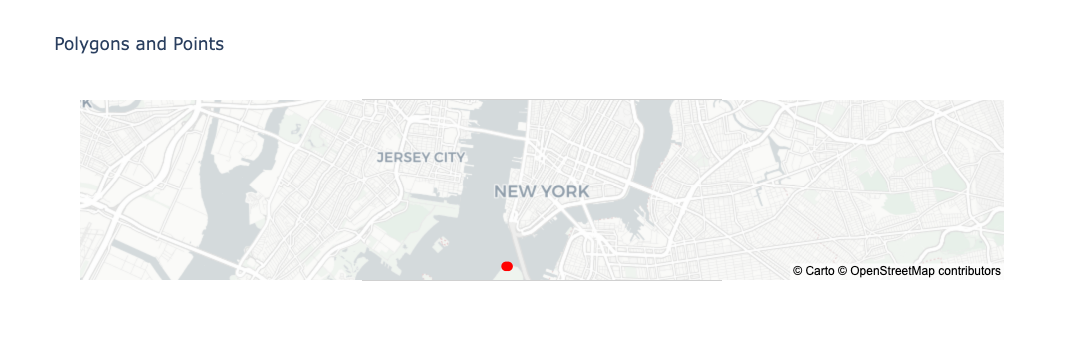

In [103]:
import geopandas as gpd
import pandas as pd
import plotly.graph_objects as go

# Convert GeoPandas DataFrame to Pandas DataFrame
df = pd.DataFrame(MNdups.drop('geometry', axis=1))


# Create a trace for points
point_trace = go.Scattermapbox(
    lon=df['Longitude'],
    lat=df['Latitude'],
    mode='markers',
    marker=dict(color='red', size=10)
)

# Create the layout
layout = go.Layout(
    title='Polygons and Points',
    showlegend=False,
    mapbox=dict(
        style='carto-positron',
        center=dict(lat=40.7128, lon=-74.0060),
        zoom=11
    )
)

# Create the figure
fig = go.Figure(data=[polygon_trace, point_trace], layout=layout)

# Display the plot
fig.show()


In [52]:

import matplotlib.pyplot as plt #if using matplotlib
import plotly.express as px #if using plotly


In [61]:
MNdups.columns

Index(['Borough', 'Block', 'Lot', 'CD', 'BCT2020', 'BCTCB2020', 'CT2010',
       'CB2010', 'SchoolDist', 'Council', 'ZipCode', 'FireComp', 'PolicePrct',
       'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
       'Address', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'Overlay1', 'Overlay2', 'SPDist1', 'SPDist2', 'SPDist3', 'LtdHeight',
       'SplitZone', 'BldgClass', 'LandUse', 'Easements', 'OwnerType',
       'OwnerName', 'LotArea', 'BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'AreaSource', 'NumBldgs', 'NumFloors', 'UnitsRes', 'UnitsTotal',
       'LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
       'IrrLotCode', 'LotType', 'BsmtCode', 'AssessLand', 'AssessTot',
       'ExemptTot', 'YearBuilt', 'YearAlter1', 'YearAlter2', 'HistDist',
       'Landmark', 'BuiltFAR', 'ResidFAR', 'CommFAR', 'FacilFAR', 'BoroCode',
       'BBL', 'CondoNo', 'Tract2

In [122]:
gdf.BBL.nunique()

856903

In [123]:
pluto.bbl.nunique()

859068

In [125]:
len(gdf)

856903

## INVESTIGATE DUPLICATIONS, BY PROP TYPE

In [159]:
dups = in_pluto.groupby(['address','zipcode']).filter(lambda x: len(x) == 1).sort_values('address')

In [ ]:
dups[~dups['address'].str.match(r'^\d')].bldgclass.value_counts()

V0    141
V1     50
B2     26
Z9     17
B1      9
G7      6
Q0      6
A4      6
C0      6
G0      5
Y4      4
K1      4
V2      4
Q1      3
U6      3
D7      3
A9      3
B9      3
A1      3
E9      2
T1      2
U9      2
U1      2
G6      2
V7      2
K4      2
C1      2
D3      2
Z0      2
I1      1
V3      1
I5      1
U7      1
P1      1
Q9      1
U2      1
G1      1
Name: bldgclass, dtype: int64

In [165]:
in_pluto = in_pluto.groupby(['address','zipcode']).filter(lambda x: len(x) == 1)

In [178]:
pluto[pluto.bbl == 1006020083]

,borough,block,lot,cd,bct2020,bctcb2020,ct2010,cb2010,schooldist,council,zipcode,firecomp,policeprct,healthcenterdistrict,healtharea,sanitboro,sanitdistrict,sanitsub,address,zonedist1,zonedist2,zonedist3,zonedist4,overlay1,overlay2,spdist1,spdist2,spdist3,ltdheight,splitzone,bldgclass,landuse,easements,ownertype,ownername,lotarea,bldgarea,comarea,resarea,officearea,...,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,zonemap,zmcode,sanborn,taxmap,edesignum,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
181255,MN,602,83,102.0,1006900.0,1.006900e+10,69.0,1007.0,2.0,3.0,10014.0,E024,6.0,15.0,6400.0,1.0,2.0,1B,115 LEROY STREET,M1-5/R7X,NaN,NaN,NaN,NaN,NaN,MX-6,NaN,NaN,NaN,N,A4,1.0,0.0,NaN,SHINOBI 115L LLC,2507.0,3442.0,0.0,3442.0,0.0,...,25.0,44.24,NaN,3.0,N,5.0,2.0,31980.0,183840.0,0.0,2017.0,2017.0,0.0,NaN,NaN,1.37,5.0,5.0,5.0,1,1.006020e+09,NaN,69.0,982134.0,205427.0,12a,NaN,103 001,10208.0,R-141,1.006020e+09,10/25/2017,1,NaN,NaN,23v1,NaN,40.730526,-74.007635,NaN


In [185]:
in_pluto[(in_pluto.borough=='BK')].sample(5)

,borough,block,lot,cd,bct2020,bctcb2020,ct2010,cb2010,schooldist,council,zipcode,firecomp,policeprct,healthcenterdistrict,healtharea,sanitboro,sanitdistrict,sanitsub,address,zonedist1,zonedist2,zonedist3,zonedist4,overlay1,overlay2,spdist1,spdist2,spdist3,ltdheight,splitzone,bldgclass,landuse,easements,ownertype,ownername,lotarea,bldgarea,comarea,resarea,officearea,...,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,zonemap,zmcode,sanborn,taxmap,edesignum,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
1119,BK,5984,55,310.0,3016600.0,3.016600e+10,166.0,1000.0,20.0,43.0,11228,E284,68.0,31.0,7820.0,3.0,10.0,4E,1057 80TH STREET,R4-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,A1,1.0,0.0,NaN,"CHEN, YAN",2350.0,1632.0,0.0,1632.0,0.0,...,16.0,47.0,N,1.0,N,5.0,2.0,22080.0,78960.0,1460.0,1925.0,2018.0,0.0,NaN,NaN,0.69,0.75,0.0,2.0,3,3.059840e+09,NaN,166.0,979981.0,165435.0,22b,NaN,311 062,31805.0,NaN,NaN,NaN,1,NaN,NaN,23v1,NaN,40.620756,-74.015378,NaN
2097,BK,7666,106,318.0,3074600.0,3.074600e+10,746.0,2005.0,22.0,45.0,11210,E309,63.0,35.0,8810.0,3.0,18.0,6E,3009 AVENUE N,R4,NaN,NaN,NaN,C2-2,NaN,NaN,NaN,NaN,NaN,N,S1,4.0,0.0,NaN,RO ROB REALTY CORP,1140.0,1824.0,912.0,912.0,0.0,...,19.0,48.0,N,0.0,N,5.0,0.0,12120.0,37320.0,0.0,1985.0,0.0,0.0,NaN,NaN,1.60,0.75,0.0,2.0,3,3.076660e+09,NaN,746.0,999597.0,164234.0,23b,NaN,313 008,32304.0,NaN,3.076660e+09,09/17/1991,1,NaN,NaN,23v1,NaN,40.617447,-73.944720,NaN
6385,BK,7714,71,318.0,3064000.0,3.064000e+10,640.0,1002.0,22.0,46.0,11234,E309,63.0,35.0,8821.0,3.0,18.0,7D,1768 EAST 32ND STREET,R3-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,A5,1.0,0.0,NaN,"CHAUDHRY, HANIF",1799.0,1728.0,0.0,1152.0,0.0,...,18.0,32.0,N,3.0,N,5.0,1.0,11040.0,47340.0,23670.0,1935.0,0.0,0.0,NaN,NaN,0.96,0.50,0.0,1.0,3,3.077140e+09,NaN,640.0,1001323.0,162026.0,23b,NaN,319 018,32305.0,NaN,NaN,NaN,1,NaN,NaN,23v1,NaN,40.611384,-73.938509,NaN
224,BK,2414,7501,301.0,3055100.0,3.055100e+10,551.0,1002.0,14.0,33.0,11249,E221,90.0,30.0,400.0,3.0,1.0,2B,266 KENT AVENUE,C6-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,RM,4.0,0.0,NaN,260 KENT LLC,26021.0,356544.0,136606.0,219938.0,0.0,...,192.0,166.0,NaN,1.0,N,0.0,5.0,1170901.0,46546651.0,0.0,2018.0,0.0,0.0,NaN,NaN,13.70,6.02,6.0,6.5,3,3.024148e+09,5071.0,551.0,993507.0,200117.0,12c,NaN,303 007,30806.0,NaN,NaN,NaN,1,NaN,NaN,23v1,NaN,40.715947,-73.966607,NaN
1299,BK,7560,14,317.0,3078602.0,3.078602e+10,786.0,3003.0,22.0,45.0,11210,L157,67.0,35.0,7410.0,3.0,17.0,5D,771 EAST 32ND STREET,R6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,C2,2.0,0.0,NaN,771 EAST 32 LLC,2050.0,6096.0,0.0,6096.0,0.0,...,20.0,57.0,NaN,2.0,N,5.0,2.0,69300.0,360900.0,345955.0,2019.0,0.0,0.0,NaN,NaN,2.97,2.43,0.0,4.8,3,3.075600e+09,NaN,786.0,999410.0,169678.0,23a,NaN,315 003,3.0,NaN,3.075600e+09,05/08/2019,1,NaN,NaN,23v1,NaN,40.632390,-73.945382,NaN


In [193]:
in_pluto[(in_pluto.address=='1880 1ST AVENUE')]

,borough,block,lot,cd,bct2020,bctcb2020,ct2010,cb2010,schooldist,council,zipcode,firecomp,policeprct,healthcenterdistrict,healtharea,sanitboro,sanitdistrict,sanitsub,address,zonedist1,zonedist2,zonedist3,zonedist4,overlay1,overlay2,spdist1,spdist2,spdist3,ltdheight,splitzone,bldgclass,landuse,easements,ownertype,ownername,lotarea,bldgarea,comarea,resarea,officearea,...,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,zonemap,zmcode,sanborn,taxmap,edesignum,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
5581,MN,1691,3,111.0,1016200.0,1.016201e+10,162.0,5011.0,4.0,8.0,10029,L043,23.0,12.0,2600.0,1.0,11.0,1B,1880 1ST AVENUE,R7-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,G6,10.0,0.0,X,NYC HEALTH AND HOSPITALS CORPORATION,34480.0,0.0,NaN,NaN,NaN,...,0.0,0.0,NaN,0.0,Y,3.0,5.0,1490850.0,1490850.0,1490850.0,1962.0,0.0,0.0,NaN,NaN,0.0,3.44,0.0,6.5,1,1.016910e+09,NaN,162.0,999889.0,224941.0,6b,NaN,108S042,10606.0,NaN,1.016910e+09,04/06/2017,1,1.0,1.0,23v1,t,40.784073,-73.943528,NaN


In [167]:
in_pluto[in_pluto.borough=='MN'].sample(10)

,borough,block,lot,cd,bct2020,bctcb2020,ct2010,cb2010,schooldist,council,zipcode,firecomp,policeprct,healthcenterdistrict,healtharea,sanitboro,sanitdistrict,sanitsub,address,zonedist1,zonedist2,zonedist3,zonedist4,overlay1,overlay2,spdist1,spdist2,spdist3,ltdheight,splitzone,bldgclass,landuse,easements,ownertype,ownername,lotarea,bldgarea,comarea,resarea,officearea,...,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,zonemap,zmcode,sanborn,taxmap,edesignum,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
36,MN,1589,1,108.0,1013601.0,1.013601e+10,136.00,5000.0,2.0,5.0,10028,E022,19.0,13.0,3800.0,1.0,8.0,3B,F D R DRIVE,R10A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,T2,7.0,0.0,C,NYC DEPARTMENT OF SMALL BUSINESS SERVICES,16447.0,0.0,NaN,NaN,NaN,...,0.00,0.00,N,0.0,Y,5.0,0.0,8725050.0,8725050.0,8725050.0,0.0,0.0,0.0,NaN,NaN,0.00,10.00,0.0,10.0,1,1.015890e+09,NaN,136.0,999230.0,220431.0,9a,NaN,108S029,10516.0,NaN,NaN,NaN,1,1.0,1.0,23v1,t,40.771696,-73.945917,NaN
2485,MN,1719,1,111.0,1019800.0,1.019800e+10,198.00,2000.0,5.0,9.0,10027,L014,25.0,11.0,1600.0,1.0,11.0,3B,18 MT MORRIS PARK WEST,PARK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,Q1,9.0,0.0,C,NYC DEPARTMENT OF PARKS AND RECREATION,883659.0,22800.0,22800.0,0.0,0.0,...,70.00,150.00,N,1.0,N,3.0,0.0,5129550.0,6172650.0,6172650.0,1970.0,0.0,0.0,Individual Landmark,INDIVIDUAL LANDMARK,0.03,0.00,0.0,0.0,1,1.017190e+09,NaN,198.0,999844.0,232377.0,6a,Y,107N076,10607.0,NaN,NaN,NaN,1,NaN,NaN,23v1,t,40.804483,-73.943673,NaN
5581,MN,1691,3,111.0,1016200.0,1.016201e+10,162.00,5011.0,4.0,8.0,10029,L043,23.0,12.0,2600.0,1.0,11.0,1B,1880 1ST AVENUE,R7-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,G6,10.0,0.0,X,NYC HEALTH AND HOSPITALS CORPORATION,34480.0,0.0,NaN,NaN,NaN,...,0.00,0.00,NaN,0.0,Y,3.0,5.0,1490850.0,1490850.0,1490850.0,1962.0,0.0,0.0,NaN,NaN,0.00,3.44,0.0,6.5,1,1.016910e+09,NaN,162.0,999889.0,224941.0,6b,NaN,108S042,10606.0,NaN,1.016910e+09,04/06/2017,1,1.0,1.0,23v1,t,40.784073,-73.943528,NaN
2161,MN,1958,13,110.0,1021500.0,1.021500e+10,215.00,2001.0,5.0,9.0,10027,E037,32.0,11.0,8520.0,1.0,10.0,3A,2435 FREDERICK DOUGLASS BOULEVARD,R8,NaN,NaN,NaN,C1-4,NaN,NaN,NaN,NaN,NaN,N,K4,4.0,0.0,NaN,2437 FDB DEVELOPMENT LLC,14647.0,11838.0,11838.0,0.0,5919.0,...,74.00,61.00,NaN,1.0,N,5.0,0.0,329400.0,744982.0,0.0,0.0,0.0,0.0,NaN,NaN,0.81,6.02,0.0,6.5,1,1.019580e+09,NaN,215.0,998413.0,235814.0,6a,NaN,1,1.0,NaN,1.019580e+09,10/18/2022,1,NaN,NaN,23v1,NaN,40.813919,-73.948834,NaN
3498,MN,602,86,102.0,1006900.0,1.006900e+10,69.00,1007.0,2.0,3.0,10014,E024,6.0,15.0,6400.0,1.0,2.0,2B,GREENWICH STREET,M1-5/R7X,NaN,NaN,NaN,NaN,NaN,MX-6,NaN,NaN,NaN,N,V1,11.0,0.0,NaN,UNAVAILABLE OWNER,2524.0,0.0,NaN,NaN,NaN,...,0.00,0.00,NaN,0.0,N,0.0,5.0,387450.0,387450.0,0.0,0.0,0.0,0.0,NaN,NaN,0.00,5.00,5.0,5.0,1,1.006020e+09,NaN,69.0,982166.0,205525.0,12a,NaN,103 001,10208.0,R-141,1.006020e+09,10/25/2017,1,NaN,NaN,23v1,NaN,40.730795,-74.007519,NaN
2546,MN,282,7503,103.0,1000800.0,1.000801e+10,8.00,6002.0,2.0,1.0,10002,E009,5.0,14.0,7800.0,1.0,3.0,1A,100 EAST BROADWAY,C6-1G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,RC,5.0,0.0,NaN,TWO PIKE LLC,9825.0,97209.0,97209.0,0.0,46701.0,...,75.33,130.25,NaN,0.0,Y,0.0,5.0,2950648.0,11508750.0,0.0,2017.0,2017.0,0.0,NaN,NaN,9.89,3.44,6.0,4.8,1,1.002828e+09,2892.0,8.0,986125.0,199438.0,12d,NaN,101N054,10107.0,NaN,NaN,NaN,1,NaN,NaN,23v1,NaN,40.714088,-73.993236,NaN
8,MN,1377,7504,108.0,1011401.0,1.011401e+10,114.01,2000.0,2.0,4.0,10065,E039,19.0,13.0,4800.0,1.0,8.0,1A,815 5TH AVNENUE,R10,NaN,NaN,NaN,NaN,NaN,PI,NaN,NaN,NaN,N,RR,4.0,0.0,NaN,"EIGHT HUNDRED AND FIFTEEN FIFTH AVENUE, LLC",2550.0,25023.0,0.0,25023.0,0.0,...,25.50,100.00,NaN,3.0,N,0.0,5.0,472501.0,9014401.0,0.0,1910.0,0.0,0.0,NaN,NaN,9.81,10.00,0.0,10.0,1,1.013778e+09,3004.0,11401.0,992270.0,218504.0,8c,NaN,106E040,10508.0,NaN,N

In [163]:
dups[dups['address'].str.match(r'^\d')]

,borough,block,lot,cd,bct2020,bctcb2020,ct2010,cb2010,schooldist,council,zipcode,firecomp,policeprct,healthcenterdistrict,healtharea,sanitboro,sanitdistrict,sanitsub,address,zonedist1,zonedist2,zonedist3,zonedist4,overlay1,overlay2,spdist1,spdist2,spdist3,ltdheight,splitzone,bldgclass,landuse,easements,ownertype,ownername,lotarea,bldgarea,comarea,resarea,officearea,...,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,zonemap,zmcode,sanborn,taxmap,edesignum,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
4301,BK,8914,460,315.0,3062800.0,3.062800e+10,628.00,4005.0,22.0,46.0,11229,E321,61.0,37.0,8900.0,3.0,15.0,4D,110 EATON COURT,R4-1,NaN,NaN,NaN,NaN,NaN,CR-4,NaN,NaN,NaN,N,G0,10.0,0.0,NaN,"COLLEY, FREDEIC W",1799.0,0.0,NaN,NaN,NaN,...,18.0,20.0,N,0.0,N,5.0,5.0,8940.0,19680.0,0.0,1925.0,0.0,0.0,NaN,NaN,0.00,0.75,0.0,2.0,3,3.089140e+09,NaN,628.0,1005273.0,154143.0,29a,NaN,319 039,32605.0,NaN,NaN,NaN,1,1.0,1.0,23v1,NaN,40.589738,-73.924307,NaN
688,BK,8914,458,315.0,3062800.0,3.062800e+10,628.00,4005.0,22.0,46.0,11229,E321,61.0,37.0,8900.0,3.0,15.0,4D,110 EATON COURT,R4-1,NaN,NaN,NaN,NaN,NaN,CR-4,NaN,NaN,NaN,N,A1,1.0,0.0,NaN,FRED COLLEY,1799.0,1059.0,0.0,1059.0,0.0,...,24.0,26.0,N,1.0,N,5.0,2.0,6780.0,33900.0,1460.0,1925.0,0.0,0.0,NaN,NaN,0.59,0.75,0.0,2.0,3,3.089140e+09,NaN,628.0,1005247.0,154173.0,29a,NaN,319 039,32605.0,NaN,NaN,NaN,1,1.0,1.0,23v1,NaN,40.589821,-73.924400,NaN
616,BK,8932,642,315.0,3062800.0,3.062800e+10,628.00,1002.0,22.0,46.0,11229,E321,61.0,37.0,8900.0,3.0,15.0,4D,28 CELESTE COURT,R4-1,NaN,NaN,NaN,NaN,NaN,CR-4,NaN,NaN,NaN,N,A1,1.0,0.0,NaN,WILLIAM MC CAFFREY,3570.0,1240.0,0.0,1240.0,0.0,...,25.0,40.0,N,1.0,N,3.0,5.0,17460.0,36720.0,1460.0,1920.0,1997.0,1997.0,NaN,NaN,0.35,0.75,0.0,2.0,3,3.089321e+09,NaN,628.0,1004608.0,155171.0,29a,NaN,319 038,32605.0,NaN,NaN,NaN,1,NaN,1.0,23v1,NaN,40.592561,-73.926698,NaN
464,BK,8932,638,315.0,3062800.0,3.062800e+10,628.00,1002.0,22.0,46.0,11229,E321,61.0,37.0,8900.0,3.0,15.0,4D,28 CELESTE COURT,R4-1,NaN,NaN,NaN,NaN,NaN,CR-4,NaN,NaN,NaN,N,V0,11.0,0.0,NaN,"KNIGHT, ARTHUR",1785.0,0.0,NaN,NaN,NaN,...,0.0,0.0,NaN,0.0,N,5.0,5.0,5520.0,5520.0,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.75,0.0,2.0,3,3.089321e+09,NaN,628.0,1004575.0,155209.0,29a,NaN,319 038,32605.0,NaN,NaN,NaN,1,NaN,1.0,23v1,NaN,40.592666,-73.926817,NaN
6625,QN,16156,162,414.0,4094201.0,4.094201e+10,942.01,1015.0,27.0,32.0,11694,E268,100.0,45.0,3700.0,4.0,14.0,2C,320 BEACH 100TH STREET,R4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,Z0,1.0,0.0,NaN,"KELLY, SHANE",1312.0,92.0,92.0,0.0,0.0,...,0.0,0.0,NaN,0.0,N,0.0,5.0,3595.0,10785.0,0.0,0.0,0.0,0.0,NaN,NaN,0.07,0.75,0.0,2.0,4,4.161560e+09,NaN,94201.0,1033446.0,152626.0,30c,NaN,4,4.0,NaN,4.161560e+09,12/15/2022,1,NaN,1.0,23v1,NaN,40.585463,-73.822881,NaN
2875,QN,16156,149,414.0,4094201.0,4.094201e+10,942.01,1019.0,27.0,32.0,11694,E268,100.0,45.0,3700.0,4.0,14.0,2C,320 BEACH 100TH STREET,R4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,A2,1.0,0.0,NaN,"KELLY, SHANE",1310.0,838.0,0.0,838.0,0.0,...,35.0,24.0,NaN,1.0,N,0.0,5.0,3589.0,10768.0,0.0,1930.0,0.0,0.0,NaN,NaN,0.64,0.75,0.0,2.0,4,4.161560e+09,NaN,94201.0,1033496.0,152589.0,30c,NaN,4,4.0,NaN,4.161560e+09,12/15/2022,1,NaN,1.0,23v1,NaN,40.585361,-73.822701,NaN
967,BK,5875,33,310.0,3013400.0,3.013400e+10,134.00,1001.0,20.0,43.0,11209,L109,68.0,31.0,7920.0,3.0,10.0,1C,641 OVINGTON AVENUE,R4-1,NaN,NaN,NaN,NaN,NaN,BR,NaN,NaN,NaN,N,V0,11.0,0.0,NaN,643 OVINGTON INC,2648.0,0.0,NaN,NaN,NaN,...,0.0,0.0,NaN,0.0,Y,5.0,5.0,16380.0,16380.0,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.75,0.0,2.0,3,3.058750e+09,NaN,134.0,979409.0,169211.0,22a,NaN,3,3.0,NaN,3.058750e+09,05/04/2020,1,NaN,NaN,23v1,NaN,40.631120,-74.017441,NaN
5294,BK,5875,32,310.0,3013400.0,3.013400e+10,134.00,1001.0,20.0,43.0,11209,L109,68.0,31.0,7920.0,3.0,10.0,1C,641 OVINGTON AVENUE,R4-1,NaN,NaN,Na